## Unveiling Coral Reef Vulnerability: Harnessing the Power of Open-Source Technology for Python Geoprocessing and Sea Surface Temperature Anomaly Visualization

by Michaela Christine Palmer

A thesis submitted to Johns Hopkins University in conformity with the requirements for the degree of Master of Science




Baltimore, Maryland 

August 2023




### Introduction

Coral reefs are invaluable ecosystems that play a critical role in sustaining the health and biodiversity of our oceans and the overall well-being of our planet. However, they face significant threats from climate change, particularly the escalating sea temperatures that trigger widespread coral bleaching events. To address this urgent challenge, this study focuses on identifying areas at a higher risk of coral bleaching by leveraging sea surface temperature (SST) anomaly data and precise coral reef location information.

The study harnesses a comprehensive global dataset of SST anomalies provided by the National Oceanic and Atmospheric Administration (NOAA). This dataset combines diverse sources such as satellite observations, ship-based measurements, and buoy data to deliver a detailed understanding of temperature variations across the world's oceans. By analyzing this wealth of information, regions exhibiting substantial positive SST anomalies are pinpointed, serving as potential indicators of heightened coral bleaching risk.

To augment the analysis, the study incorporates data from esteemed organizations including the UNEP World Conservation Monitoring Centre (UNEP-WCMC), WorldFish Centre, WRI (World Resources Institute), and TNC (The Nature Conservancy). These organizations have compiled an extensive and up-to-date dataset on the global distribution of warm-water coral reefs. The combination of SST anomaly data and precise coral reef locations enables the creation of an interactive web map, providing a visual representation of coral areas in conjunction with their corresponding SST anomalies.

Harnessing the power of Python and employing libraries such as Pandas, GeoPandas, and Rasterstats, the study ensures efficient data processing, extraction, and analysis. These tools enable researchers to associate the SST anomaly values with their respective coral reef locations, facilitating the generation of insightful findings. The culmination of this research effort is presented in a comprehensive notebook, which serves as the main deliverable of the capstone project.

The notebook addresses two primary objectives: first, it assesses high-risk regions for coral bleaching in tropical coral reefs based on SST anomaly data, providing a valuable tool for scientists and policymakers to prioritize conservation efforts. Second, the notebook offers an interactive platform for open-source geospatial Python processing. Users can explore and analyze the data intuitively, empowering them to delve deeper into the intricate dynamics between coral reef health and SST anomalies.

In conclusion, this study contributes valuable insights into the identification of coral reef areas susceptible to bleaching events. By utilizing cutting-edge data analysis techniques and leveraging a rich dataset, this research endeavors to support effective management strategies and conservation measures, ensuring the preservation and vitality of these crucial marine ecosystems.


To begin, set up your notebook by importing the required Python libraries:

In [1]:
import os
import time
import numpy as np
import pandas as pd

import netCDF4 as nc

import xarray as xr
import rasterio as rio
import rioxarray
import geopandas as gpd
import rasterstats as rstats
from shapely.geometry import mapping


from datetime import datetime
import requests
import zipfile
import io
import datetime

import ipywidgets as widgets
from IPython.display import display

import matplotlib.pyplot as plt
import plotly.express as px

## 1. Datasets and Data Ingestion 

### Global Distribution of Coral Reefs

The presented dataset represents a comprehensive global compilation of warm-water coral reefs in tropical and subtropical regions. It stands as the most extensive and up-to-date dataset available, serving as a fundamental baseline map for future, more intricate studies. This valuable dataset is a collaborative effort between the UNEP World Conservation Monitoring Centre (UNEP-WCMC), the WorldFish Centre, WRI (World Resources Institute), and TNC (The Nature Conservancy). It combines information from multiple sources, including the Millennium Coral Reef Mapping Project (IMaRS-USF and IRD 2005, IMaRS-USF 2005) and the World Atlas of Coral Reefs (Spalding et al. 2001), ensuring its comprehensive nature and accuracy.

By emphasizing the dataset's global scope, its significance as a foundation for future detailed research, and providing explicit acknowledgment of the contributing organizations and data sources, the improved version provides a clearer and more informative description.


Data Source:

https://data.unep-wcmc.org/datasets/1


Citation: 

UNEP-WCMC, WorldFish Centre, WRI, TNC. (2021). Global distribution of warm-water coral reefs, compiled from multiple sources including the Millennium Coral Reef Mapping Project (Version 4.1) [Data set]. Cambridge, UK: UN Environment World Conservation Monitoring Centre. https://doi.org/10.34892/t2wk-5t34 

The function below reads a shapefile from the  UN Environment Programme (UNEP) website, which enables the user to always acess the most updated shapefile available:

In [2]:
def read_shapefile_from_url(url, shape_type):
    local_path = "tmp/"
    print("Downloading shapefile...")
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Done")
    z.extractall(path=local_path)  # extract to folder
    filenames = [
        y
        for y in sorted(z.namelist())
        for ending in ["dbf", "prj", "shp", "shx"]
        if y.endswith(ending) and shape_type in y
    ]
    dbf, prj, shp, shx = [filename for filename in filenames]
    gdf = gpd.read_file(local_path + shp)
    print(f"Shape of the DataFrame: {gdf.shape}")
    print(f"Projection of DataFrame: {gdf.crs}")
    gdf.columns = gdf.columns.str.lower()
    
    return gdf

We can read the coral reef data and check the shape of the GeoDataFrame:

In [3]:
coral_poly = read_shapefile_from_url(
    "https://datadownload-production.s3.us-east-1.amazonaws.com/WCMC008_CoralReefs2021_v4_1.zip",
    "Py",
)

Done
Shape of the DataFrame: (17504, 19)
Projection of DataFrame: EPSG:4326


### NOAA OI SST V2 High-Resolution Dataset

The NOAA OI SST V2 High-Resolution Dataset is a valuable resource for studying sea surface temperatures (SST) and ice conditions. This dataset covers a global grid with a high resolution of 1/4° and spans from September 1981 onwards. It utilizes a blend of data from various satellite sensors, including AVHRR and VIIRS, to provide a comprehensive and accurate representation of daily SST.

The spatial coverage of the dataset encompasses a global grid with a resolution of 0.25° latitude by 0.25° longitude, resulting in a grid size of 1440x720. The longitude ranges from 0.125°E to 359.875°E, while the latitude spans from 89.875°S to 89.875°N.

The main variable captured by this dataset is the sea surface temperature anomalies (anom), measured in degrees Celsius. These anomalies represent the deviation from a 1971-2000 climatology, allowing for the assessment of temperature variations over time. The data is provided at the surface level, providing insights into the temperature dynamics at the sea surface.

The NOAA OI SST V2 High-Resolution Dataset offers a comprehensive and detailed representation of global sea surface temperature anomalies, enabling researchers and scientists to study and analyze the dynamic nature of ocean temperatures on a daily basis.


Data Source:
https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html

Citation:

Huang, B., Liu, C., Banzon, V., Freeman, E., Graham, G., Hankins, B., Smith, T., & Zhang, H.-M. (2021). Improvements of the Daily Optimum Interpolation Sea Surface Temperature (DOISST) Version 2.1. Journal of Climate, 34, 2923-2939. https://doi.org/10.1175/JCLI-D-20-0166.1 

NetCDF (network Common Data Form) is a file format for storing multidimensional scientific data (variables) such as temperature, humidity, pressure, wind speed, and direction.

We can load and read the NetCDF file to create a new Dataset using the library xarray's `open_dataset()`:

In [5]:
fname = "sst.day.anom.2023.nc"
rawfile = f"data/{fname}"

ds = xr.open_dataset(rawfile, mask_and_scale=True, decode_times=True, decode_coords="all")

display(ds)

<xarray.Dataset>
Dimensions:  (time: 166, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-06-15
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    anom     (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

### Global Oceans and Seas

The provided dataset delineates the boundaries of ten primary oceans and seas, namely the Arctic Ocean, North Atlantic Ocean, South Atlantic Ocean, North Pacific Ocean, South Pacific Ocean, Southern Ocean, Indian Ocean, Baltic Sea, Mediterranean Sea, and the South China and Eastern Archipelagic Seas. These boundary demarcations are primarily derived from the renowned publication 'Limits of Oceans & Seas, Special Publication No. 23,' issued by the International Hydrographic Organization (IHO) in 1953. The dataset adheres to the World Geodetic System of 1984 (WGS84) and was meticulously compiled by the Flanders Marine Data Centre, ensuring accuracy and reliability in its representation of these oceanic and sea divisions.


Data Source:
https://www.marineregions.org/

Citation:

Flanders Marine Institute. (2021). Global Oceans and Seas (Version 1) [Data set]. https://doi.org/10.14284/542 

Load Global Ocean and Seas shapefile:

In [6]:
oceans = gpd.read_file("data/goas_v01")

## 2. Data Cleaning and Manipulation

### Global Distribution of Coral Reefs

We can select the columns of value and convert the primary 'name' field to titlecase for proper formatting:

In [7]:
coral_poly = coral_poly[
    [
        "name",
        "layer_name",
        "family",
        "genus",
        "species",
        "data_type",
        "start_date",
        "end_date",
        "date_type",
        "verif",
        "loc_def",
        "survey_met",
        "gis_area_k",
        "rep_area_k",
        "geometry",
    ]
]

coral_poly["name"] = coral_poly["name"].str.title()

We project the coral data into the World Mercator Coordinate Reference System (CRS) so we can perform a buffer in meters later on:

In [8]:
# WGS 84 / World Mercator (meters)
coral_poly = coral_poly.to_crs(3395)

We can view the first 5 rows of the coral boundaries shapefile:

In [9]:
coral_poly.head()

name layer_name        family         genus       species  \
0  Not Reported        CRR  Not Reported  Not Reported  Not Reported   
1  Not Reported        CRR  Not Reported  Not Reported  Not Reported   
2  Not Reported        CRR  Not Reported  Not Reported  Not Reported   
3  Not Reported        CRR  Not Reported  Not Reported  Not Reported   
4  Not Reported        CRR  Not Reported  Not Reported  Not Reported   

      data_type    start_date      end_date date_type         verif  \
0  Not Reported  Not Reported  Not Reported        ND  Not Reported   
1  Not Reported  Not Reported  Not Reported        ND  Not Reported   
2  Not Reported  Not Reported    31/12/2009        -Y  Not Reported   
3  Not Reported  Not Reported  Not Reported        ND  Not Reported   
4  Not Reported  Not Reported  Not Reported        ND  Not Reported   

                       loc_def    survey_met  gis_area_k    rep_area_k  \
0  Coral line buffered to 300m  Not Reported    5.059916  Not Reported   
1  Coral line buffered to 300m  Not Reported    5.450101  Not Reported   
2                        coral  Not Reported   32.351025  Not Reported   
3                        coral  Not Reported    1.823247  Not Reported   
4                        coral  Not Reported   34.815939  Not Reported   

                                            geometry  
0  POLYGON ((5173630.159 -1333911.921, 5173964.15...  
1  POLYGON ((5144976.159 -1361072.257, 5145388.15...  
2  MULTIPOLYGON (((15898969.435 -1074998.094, 158...  
3  POLYGON ((4108485.265 2493297.954, 4107644.138...  
4  MULTIPOLYGON (((4111474.159 2493196.246, 41114...

Because of the complex geometry of the coral boundaries, we are going to use the centroids of the coral boundaries to speed up processing and allow us to create a bubble map of our results:

In [10]:
# Take centroids of polygons, maintains area field
coral_centroids = coral_poly.copy()
coral_centroids = coral_centroids.to_crs(3395)
coral_centroids["centroid"] = coral_centroids.centroid

coral_centroids = coral_centroids[
    [
        "name",
        "layer_name",
        "family",
        "genus",
        "species",
        "data_type",
        "start_date",
        "end_date",
        "date_type",
        "verif",
        "loc_def",
        "survey_met",
        "gis_area_k",
        "centroid",
    ]
]

coral_centroids = gpd.GeoDataFrame(coral_centroids, geometry="centroid", crs=3395)

### NOAA OI SST V2 High-Resolution Dataset

The NetCDF file covers a longitude range from 0 to 360, whereas the ESPG: 4326 projection system uses a longitude range from -180 to 180. To avoid encountering missing or invalid data (NaNs) for half of the map, it is necessary to perform a conversion of the longitude values.

In [11]:
ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180

ds = ds.sortby(["time", "lon"]) 
ds = ds.sortby(['lat'], ascending=False)

# Use the 4326 CRS for degrees
ds.rio.write_crs(4326, inplace=True)

<xarray.Dataset>
Dimensions:      (time: 166, lat: 720, lon: 1440)
Coordinates:
  * time         (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-06-15
  * lat          (lat) float32 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    spatial_ref  int32 0
Data variables:
    anom         (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

We need to tell the library rioxarray which dimensions correspond to x and y by calling `.set_spatial_dims()`:

In [12]:
ds = ds.rio.write_crs(4326).rio.set_spatial_dims(
    x_dim='lon',
    y_dim='lat'
).rio.write_coordinate_system()

display(ds)

<xarray.Dataset>
Dimensions:      (time: 166, lat: 720, lon: 1440)
Coordinates:
  * time         (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-06-15
  * lat          (lat) float32 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    spatial_ref  int32 0
Data variables:
    anom         (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

This code chunk involve writing and retrieving the affine transformation matrix of the dataset using the rio module. The affine transformation matrix defines the relationship between the data and its coordinate system, allowing for accurate spatial referencing and geometric transformations.


In [13]:
ds = ds.rio.write_transform(ds.rio.transform())
ds.spatial_ref.GeoTransform

'-180.0 0.25 0.0 90.0 0.0 -0.25'

This cell should return Affine (0.25, 0.0, -180.0, 0.0, -0.25, 90.0)

In [14]:
print(ds.rio.crs)
ds.rio.transform()

EPSG:4326


Affine(0.25, 0.0, -180.0,
       0.0, -0.25, 90.0)

Select the most recent day in the NetCDF file and save as a variable:

In [15]:
days = [ds['time'].values[-1]]

We will extract the SST amomaly data for this day.

### Global Oceans and Seas

We convert column names to lowercase for easy referencing:

In [16]:
oceans.columns = oceans.columns.str.lower()

We project the ocean boundaries dataset into the same CRS as the coral location data so we can clip and filter our data later on:

In [17]:
oceans = oceans.to_crs(coral_poly.crs)
ocean_names = oceans.name.to_list()
ocean_names.sort()

## 3. Data Filtering

### Selecting an Area of Interest for Analysis

We can create a function that generates an dropdown selector based on the unique values in the Global Ocean and Seas dataset:

In [18]:
drop_down = widgets.Dropdown(options=ocean_names,
                                description="Select:",
                                disabled=False)

def dropdown_handler(change):
    global selection
    print(change.new)
    selection = change.new  
drop_down.observe(dropdown_handler, names='value')

The user can select an area of interest from the dropdown to focus the analysis on a specific ocean boundary:

In [19]:
display(drop_down)

Dropdown(description='Select:', options=('Arctic Ocean', 'Baltic Sea', 'Indian Ocean', 'Mediterranean Region',…

North Atlantic Ocean


We can check the selection matches the user's choice by printing out the value of the selection variable:

In [20]:
selection

'North Atlantic Ocean'

After submitting the area of interest, the coral data is clipped and "filtered" based on the user's choice:

In [21]:
clipped_ocean = oceans.query("name == @selection")
coral_centroids_subset = gpd.clip(coral_centroids, clipped_ocean,)

We can check that the data was properly clipped by comparing the orginal and clipped data shapes:

In [22]:
print(f"Shape of original DataFrame: {coral_centroids.shape}")
print(f"Shape of filtered DataFrame: {coral_centroids_subset.shape}")

Shape of original DataFrame: (17504, 14)
Shape of filtered DataFrame: (682, 14)


## 4. Data Analysis

We will add an incrementing, unique 'coral_id' in order to join the dataset back to the centroid geometry later:

In [23]:
coral_centroids_subset.insert(0, "coral_id", range(1, 1 + len(coral_centroids_subset)))

In [24]:
coral_subset = coral_centroids_subset

### Create A Buffer Around Each Reef Point Location

The centroid of each coral reef boundary serves as the central location for that specific reef. Our objective is to extract the sea surface temperature (SST) anomaly values associated with each coral reef region of interest from the NetCDF data. To achieve this, we will generate a buffer around these centroid points to define the specific area within the plot where the data collection took place.

Make a copy of the points layer that will become a new polygon layer:

In [25]:
coral_subset_buffered = coral_subset.copy()

To generate a buffer around the points layer, we utilize the `.buffer()` method, which creates circular regions around each point with a radius of x units. The units used for the buffer coincide with the coordinate reference system (CRS) of your data. This process is commonly referred to as buffering. By performing the buffer operation, the geometry column of the new polygon layer is updated with the output of the buffer, resulting in the creation of circular regions around each point.

In [26]:
# Buffer each point using a 100 meter circle radius
# and replace the point geometry with the new buffered geometry
coral_subset_buffered["geometry"] = coral_subset_buffered.geometry.buffer(100)
coral_subset_buffered.head()

coral_id                          name layer_name        family  \
1960         1             Kepulauan Padaido        CRR  Not Reported   
1961         2  Kepulauan Padaido-Pulau Auki        CRR  Not Reported   
525          3                  Not Reported        CRR  Not Reported   
1963         4   Kepulauan Padaido-Pulau Owi        CRR  Not Reported   
1999         5                  Not Reported        CRR  Not Reported   

             genus       species     data_type    start_date      end_date  \
1960  Not Reported  Not Reported  Field survey  Not Reported  Not Reported   
1961  Not Reported  Not Reported  Field survey  Not Reported  Not Reported   
525   Not Reported  Not Reported  Not Reported    01/01/1968    31/12/1988   
1963  Not Reported  Not Reported  Field survey  Not Reported  Not Reported   
1999  Not Reported  Not Reported  Field survey    01/01/2000    31/12/2000   

     date_type         verif                      loc_def  \
1960        ND  Not Reported  Coral line buffered to 300m   
1961        ND  Not Reported  Coral line buffered to 300m   
525         YY  Not Reported                   Coral Reef   
1963        ND  Not Reported  Coral line buffered to 300m   
1999         Y  Not Reported  Coral line buffered to 300m   

                   survey_met  gis_area_k                         centroid  \
1960  British Admiralty Chart    1.241981  POINT (-8559343.390 957353.377)   
1961  British Admiralty Chart    1.242026  POINT (-8560310.296 959715.831)   
525              Not Reported    0.000204  POINT (-8611586.669 961166.703)   
1963  British Admiralty Chart    0.993637  POINT (-8530819.592 969167.524)   
1999  British Admiralty Chart    1.490434  POINT (-8506951.604 986451.106)   

                                               geometry  
1960  POLYGON ((-8559243.390 957353.377, -8559243.87...  
1961  POLYGON ((-8560210.296 959715.831, -8560210.77...  
525   POLYGON ((-8611486.669 961166.703, -8611487.15...  
1963  POLYGON ((-8530719.592 969167.524, -8530720.07...  
1999  POLYGON ((-8506851.604 986451.106, -8506852.08...

In [27]:
coral_subset_buffered = gpd.GeoDataFrame(coral_subset_buffered[["coral_id", "geometry"]], geometry="geometry", crs=3395)

In [28]:
coral_subset_buffered = coral_subset_buffered.to_crs(4326)
coral_subset_buffered = coral_subset_buffered.reset_index(drop=True)

To calculate the average value of the sea surface temperature (SST) anomaly data within each buffer we generated, we can utilize the `zonalstats` function from the rasterstats library. This function enables us to extract the mean SST anomaly value for each buffer region. By applying this operation, we obtain a GeoDataFrame where each row corresponds to a specific coral reef in the dataset, accompanied by its associated mean SST anomaly value.


In [29]:
# Get datarray for anomaly variable from the NetCDF dataset
anoms = ds['anom']

arr = []
for day in days:
    # Get values of variable per day
    data = anoms.sel(time=day)
    data_vals = data.values
    # Compute zonal statistics
    temp = pd.DataFrame(rstats.zonal_stats(
        coral_subset_buffered,
        data_vals,
        affine=ds.rio.transform(), # Use the existing affine that was checked earlier
        stats=["mean"],
        nodata=np.nan,
        all_touched=True,
    ))
    date = np.datetime_as_string(day, unit='D')    
    temp = temp.rename(columns={
        "mean":"mean_sst_anomaly",
    })
    temp.reset_index(drop=True, inplace=True)
    arr.append(temp)

arr = pd.concat(arr, axis=1)


out = pd.merge(
    coral_subset_buffered,
    arr,
    left_index=True,
    right_index=True
)

out = gpd.GeoDataFrame(out, geometry='geometry', crs=4326)

In summary, the code performs zonal statistics calculations by extracting values for each day from a NetCDF dataset, computing the mean statistic within each buffer zone defined by the 'coral_subset_buffered' GeoDataFrame. The results are stored in a new GeoDataFrame named 'out' that includes both the zonal statistics and the original geometry information.


## 5. Data Visualization

### Visualize the NOAA OI SST V2 High-Resolution Dataset

We can visualize global SST anomaly dataset:

<Axes: title={'center': 'time = 2023-06-15, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

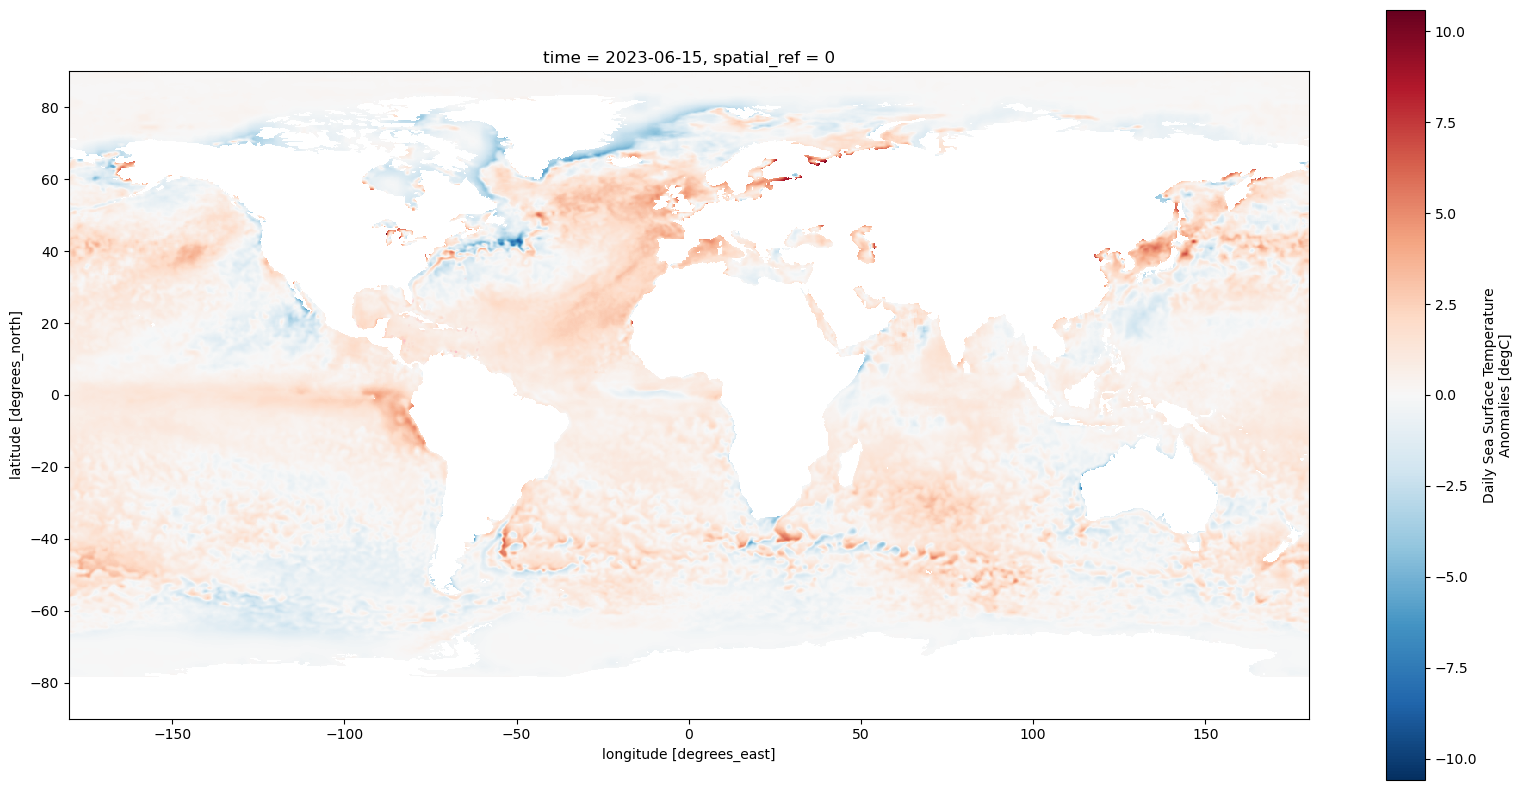

In [36]:
fig, ax = plt.subplots(figsize=(20,10))
data.plot(ax=ax)
coral_subset_buffered.plot(ax=ax, facecolor='none', edgecolor='black')

Our objective is to visualize the mean sea surface temperature (SST) anomaly values of coral reefs using a bubble map. A bubble map employs circles of varying sizes to represent numeric values within a specific geographic area. Each geographic coordinate or region is represented by a distinct bubble, allowing for a visual representation of the SST anomaly values associated with coral reefs.

Before we can visualize our `zonalstats` results as a bubble map, we need to join the results back to its centroid geometry:

In [31]:
coral_sstanom = coral_centroids_subset.merge(out[["coral_id", "mean_sst_anomaly"]], on="coral_id")

We can drop locations that returned a NaN mean value:

In [32]:
coral_sstanom = coral_sstanom.dropna(subset=["mean_sst_anomaly"])

To ensure compatibility with bubble maps, it is necessary for the marker sizes to be positive values. In order to handle negative mean anomaly values, we can calculate the absolute value of the 'mean_sst_anomaly' and introduce a new column that categorizes the anomaly as either "positive" or "negative".


In [33]:
coral_sstanom["positive_anom"] = np.where(coral_sstanom["mean_sst_anomaly"] > 0, True, False)
coral_sstanom = coral_sstanom.copy()
coral_sstanom["abs_mean_sst_anomaly"] = coral_sstanom["mean_sst_anomaly"].abs()

### Visualize the Results

Our goal is to visualize the coral reef regions that exhibit the highest positive sea surface temperature (SST) anomaly values, indicating their vulnerability to coral bleaching. To achieve this, we can utilize the `px.scatter_mapbox` function, which allows us to represent each row of the dataframe as a marker point on a geographical plot. By specifying a specific column as the size argument, we can control the size of the markers based on the corresponding values in that column. 


The color of the bubbles in the visualization serves as an intuitive indicator of the nature of the sea surface temperature (SST) anomaly. A positive SST anomaly, signifying warmer temperatures, is represented by red color, while a negative anomaly, indicating colder temperatures, is depicted using a blue color. This color scheme provides an immediate visual understanding of the SST anomalies associated with each bubble on the map.





In [34]:
# Ensure the final DataFrame is in ESPG: 4326
coral_sstanom_4326 = coral_sstanom.to_crs(4326)
fig = px.scatter_mapbox(
                        coral_sstanom_4326, 
                        lat=coral_sstanom_4326.geometry.y, 
                        lon=coral_sstanom_4326.geometry.x, 
                        size="abs_mean_sst_anomaly", 
                        color="positive_anom", 
                        category_orders={"positive_anom":list(coral_sstanom_4326.positive_anom.unique())},
                        color_discrete_sequence=["#ba2b3b", "#2b83ba"],
                        hover_name ="name",
                        hover_data= {
                            "mean_sst_anomaly": True,   
                            "gis_area_k": True,
                            "loc_def": True,
                        "positive_anom": False,
                        "abs_mean_sst_anomaly": False},
  
                        mapbox_style = 'open-street-map',
                        zoom=2.9)

fig.update_layout(
    title="Coral Reefs & Sea Surface Temperature Anomalies",
    legend_title="Anomaly Type",
    autosize=True, hovermode="closest",
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
)
)

# Change labels for legend
for i, new_name in enumerate(["Positive", "Negative"]):
    fig.data[i].name = new_name
        
fig.show()

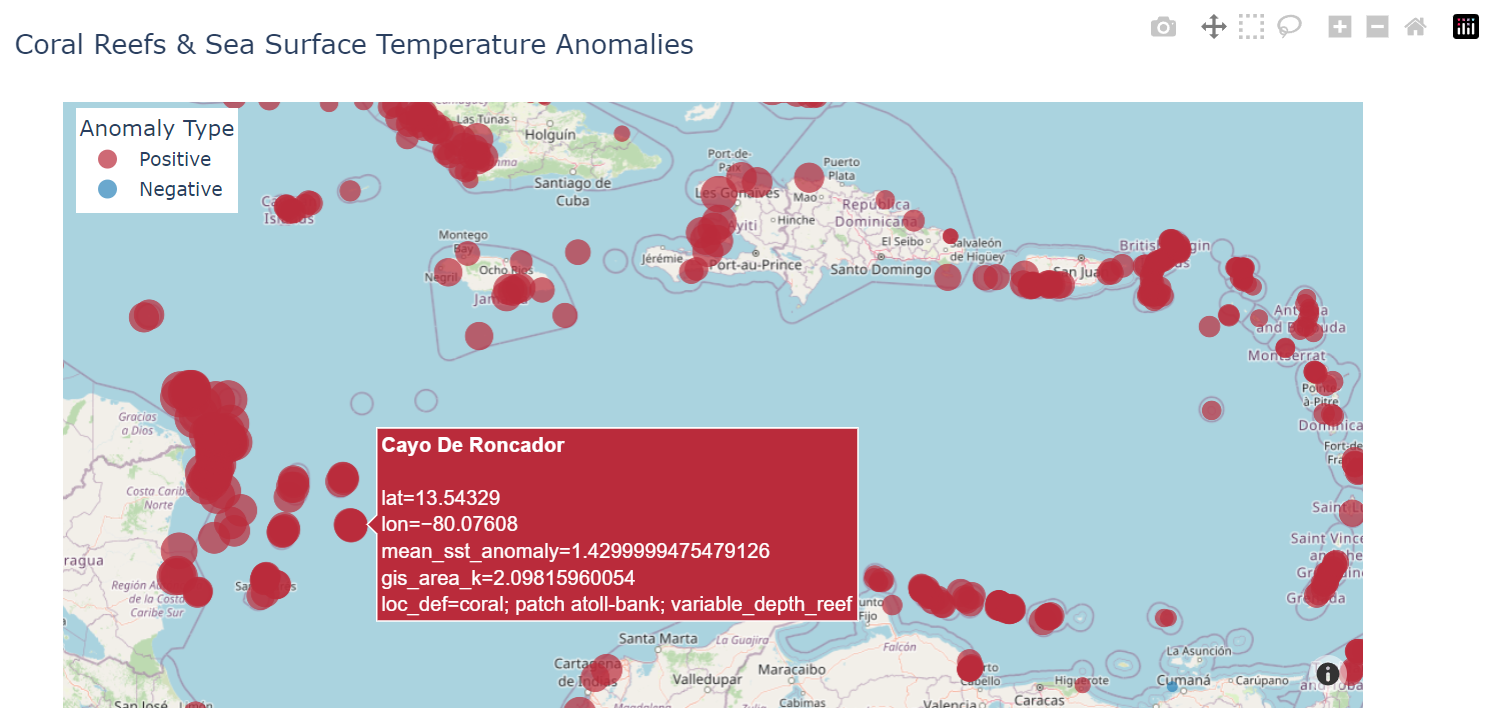

Above, we created scatter mapbox visualization with markers representing coral reefs and their associated mean SST anomalies. The visualization includes interactive features such as hover information and a legend indicating positive and negative anomalies.